In [ ]:
import os
import logging
from pathlib import Path
from typing import List, Tuple, Dict
from dataclasses import dataclass
import numpy as np
from pydub import AudioSegment
from scipy.io import wavfile
import matplotlib.pyplot as plt
from dotenv import load_dotenv
import json
from datetime import datetime
import random
from td_utils import *
%matplotlib inline

In [31]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Input, Masking, TimeDistributed, LSTM, Conv1D
from tensorflow.keras.layers import GRU, Bidirectional, BatchNormalization, Reshape
from tensorflow.keras.optimizers import Adam

In [32]:
# Load the preprocessed training examples
X = np.load("../data/processed/train/X.npy")
Y = np.load("../data/processed/train/Y.npy")

print(X.shape)
print(Y.shape)

(32, 5511, 101)
(32, 1375, 1)


In [33]:
# UNQ_C5
# GRADED FUNCTION: modelf

def model(input_shape):
    """
    Function creating the model's graph in Keras.
    
    Argument:
    input_shape -- shape of the model's input data (using Keras conventions)

    Returns:
    model -- Keras model instance
    """
    
    X_input = Input(shape = input_shape)
    
    ### START CODE HERE ###
    
    # Step 1: CONV layer (≈4 lines)
    # Add a Conv1D with 196 units, kernel size of 15 and stride of 4
    X = Conv1D(196, 15, strides=4)(X_input)
    # Batch normalization
    X = BatchNormalization()(X)
    # ReLu activation
    X = Activation('relu')(X)
    # dropout (use 0.8)
    X = Dropout(0.8)(X)                                  

    # Step 2: First GRU Layer (≈4 lines)
    # GRU (use 128 units and return the sequences)
    X = GRU(128, return_sequences=True)(X)
    # dropout (use 0.8)
    X = Dropout(0.8)(X)
    # Batch normalization.
    X = BatchNormalization()(X)                           
    
    # Step 3: Second GRU Layer (≈4 lines)
    # GRU (use 128 units and return the sequences)
    X = GRU(128, return_sequences=True)(X)
    # dropout (use 0.8)
    X = Dropout(0.8)(X)       
    # Batch normalization
    X = BatchNormalization()(X)
    # dropout (use 0.8)
    X = Dropout(0.8)(X)                                 
    
    # Step 4: Time-distributed dense layer (≈1 line)
    # TimeDistributed  with sigmoid activation 
    X = TimeDistributed(Dense(1, activation='sigmoid'))(X) 

    ### END CODE HERE ###

    model = Model(inputs = X_input, outputs = X)
    
    return model  

In [34]:
Tx = 5511
Ty = 1375
N_FREQ = 101

In [35]:
model = model(input_shape = (Tx, N_FREQ))

In [36]:
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 5511, 101)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 1375, 196)      │       297,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 1375, 196)      │           784 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 1375, 196)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 1375, 196)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_6 (GRU)                     │ (None, 1375, 128)      │       125,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 1375, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 1375, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_7 (GRU)                     │ (None, 1375, 128)      │        99,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 1375, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 1375, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 1375, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, 1375, 1)        │           129 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 523,329 (2.00 MB)

 Trainable params: 522,425 (1.99 MB)

 Non-trainable params: 904 (3.53 KB)

In [37]:
opt = Adam(learning_rate=1e-6, beta_1=0.9, beta_2=0.999)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=["accuracy"])

In [38]:
model.fit(X, Y, batch_size = 16, epochs=1)

2/2 ━━━━━━━━━━━━━━━━━━━━ 45s 3s/step - accuracy: 0.4976 - loss: 1.3069


In [39]:
# Save the model
model.save("../models/wakeword_model.h5")

In [40]:
from keras.models import load_model

model = load_model("../models/wakeword_model.h5")
print("✅ Model loaded successfully!")

✅ Model loaded successfully!


In [1]:
# Wake Word Detection - Model Training
# This notebook builds and trains a deep learning model for wake word detection
# Architecture: Conv1D → GRU → GRU → TimeDistributed Dense

# ============================================================================
# SECTION 1: Setup and Imports
# ============================================================================

import os
import logging
import json
import random
from pathlib import Path
from typing import List, Tuple, Dict
from dataclasses import dataclass
from datetime import datetime

import numpy as np
import matplotlib.pyplot as plt
from pydub import AudioSegment
from scipy.io import wavfile
from dotenv import load_dotenv

from td_utils import *

# TensorFlow/Keras imports
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.layers import (
    Dense, Activation, Dropout, Input, Masking, 
    TimeDistributed, LSTM, Conv1D, GRU, 
    Bidirectional, BatchNormalization, Reshape
)
from tensorflow.keras.optimizers import Adam

# Configure matplotlib
%matplotlib inline
plt.style.use('default')

# Set random seeds for reproducibility
np.random.seed(42)
random.seed(42)

print("✓ All libraries imported successfully!\n")

✓ All libraries imported successfully!



In [12]:
# ============================================================================
# SECTION 2: Configuration
# ============================================================================

# Model hyperparameters
Tx = 5511  # Number of time steps in input spectrogram
Ty = 1375  # Number of time steps in output
N_FREQ = 101  # Number of frequency bins

# Training configuration
BATCH_SIZE = 16
EPOCHS = 20  # Increase for actual training (e.g., 50-100)
LEARNING_RATE = 1e-6
BETA_1 = 0.9
BETA_2 = 0.999

# File paths
DATA_PATH = "../data/processed"
MODEL_PATH = "../models"
MODEL_NAME = "wakeword_model.h5"

print("="*60)
print("MODEL CONFIGURATION")
print("="*60)
print(f"Input shape: ({Tx}, {N_FREQ})")
print(f"Output shape: ({Ty}, 1)")
print(f"Batch size: {BATCH_SIZE}")
print(f"Epochs: {EPOCHS}")
print(f"Learning rate: {LEARNING_RATE}")
print("="*60 + "\n")

MODEL CONFIGURATION
Input shape: (5511, 101)
Output shape: (1375, 1)
Batch size: 16
Epochs: 20
Learning rate: 1e-06



In [13]:
# ============================================================================
# SECTION 3: Load Training Data
# ============================================================================

print("Loading preprocessed training data...")

# Load training data
X_train = np.load(f"{DATA_PATH}/train/X.npy")
Y_train = np.load(f"{DATA_PATH}/train/Y.npy")

print(f"✓ Training data loaded successfully!")
print(f"  X_train shape: {X_train.shape}")
print(f"  Y_train shape: {Y_train.shape}")
print(f"  Training samples: {X_train.shape[0]}")
print(f"  Memory usage: {X_train.nbytes / (1024**2):.2f} MB\n")

Loading preprocessed training data...
✓ Training data loaded successfully!
  X_train shape: (32, 5511, 101)
  Y_train shape: (32, 1375, 1)
  Training samples: 32
  Memory usage: 135.89 MB



In [14]:
# ============================================================================
# SECTION 4: Model Architecture
# ============================================================================

def build_model(input_shape):
    """
    Builds the wake word detection model using Keras Functional API.
    
    Architecture:
        1. Conv1D layer for feature extraction
        2. Two stacked GRU layers for temporal modeling
        3. TimeDistributed Dense layer for sequence labeling
    
    Parameters:
        input_shape (tuple): Shape of input data (Tx, N_FREQ)
    
    Returns:
        Model: Compiled Keras model
    """
    
    X_input = Input(shape=input_shape, name='input')
    
    # ========================================
    # Layer 1: Convolutional Feature Extraction
    # ========================================
    X = Conv1D(
        filters=196, 
        kernel_size=15, 
        strides=4,
        name='conv1d'
    )(X_input)
    X = BatchNormalization(name='bn_conv')(X)
    X = Activation('relu', name='relu_conv')(X)
    X = Dropout(0.8, name='dropout_conv')(X)
    
    # ========================================
    # Layer 2: First GRU Layer
    # ========================================
    X = GRU(
        units=128, 
        return_sequences=True,
        name='gru_1'
    )(X)
    X = Dropout(0.8, name='dropout_gru_1')(X)
    X = BatchNormalization(name='bn_gru_1')(X)
    
    # ========================================
    # Layer 3: Second GRU Layer
    # ========================================
    X = GRU(
        units=128, 
        return_sequences=True,
        name='gru_2'
    )(X)
    X = Dropout(0.8, name='dropout_gru_2a')(X)
    X = BatchNormalization(name='bn_gru_2')(X)
    X = Dropout(0.8, name='dropout_gru_2b')(X)
    
    # ========================================
    # Layer 4: Output Layer
    # ========================================
    X = TimeDistributed(
        Dense(1, activation='sigmoid'),
        name='time_distributed_output'
    )(X)
    
    # Create model
    model = Model(inputs=X_input, outputs=X, name='WakeWordDetector')
    
    return model


# Build the model
print("="*60)
print("BUILDING MODEL")
print("="*60)

model = build_model(input_shape=(Tx, N_FREQ))

# Display model architecture
model.summary()

print("\n✓ Model built successfully!\n")

BUILDING MODEL


Model: "WakeWordDetector"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 5511, 101)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 1375, 196)      │       297,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv (BatchNormalization)    │ (None, 1375, 196)      │           784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv (Activation)          │ (None, 1375, 196)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv (Dropout)          │ (None, 1375, 196)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 1375, 128)      │       125,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_gru_1 (Dropout)         │ (None, 1375, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_gru_1 (BatchNormalization)   │ (None, 1375, 128)      │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_2 (GRU)                     │ (None, 1375, 128)      │        99,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_gru_2a (Dropout)        │ (None, 1375, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_gru_2 (BatchNormalization)   │ (None, 1375, 128)      │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_gru_2b (Dropout)        │ (None, 1375, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_output         │ (None, 1375, 1)        │           129 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 523,329 (2.00 MB)

 Trainable params: 522,425 (1.99 MB)

 Non-trainable params: 904 (3.53 KB)


✓ Model built successfully!



In [15]:
# ============================================================================
# SECTION 5: Model Compilation
# ============================================================================

print("Compiling model...")

# Configure optimizer
optimizer = Adam(
    learning_rate=LEARNING_RATE,
    beta_1=BETA_1,
    beta_2=BETA_2
)

# Compile model
model.compile(
    loss='binary_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy']
)

print("✓ Model compiled successfully!\n")

Compiling model...
✓ Model compiled successfully!



In [16]:
# ============================================================================
# SECTION 6: Setup Training Callbacks
# ============================================================================

# Create models directory if it doesn't exist
os.makedirs(MODEL_PATH, exist_ok=True)

# Define callbacks
callbacks = [
    # Save best model
    ModelCheckpoint(
        filepath=f"{MODEL_PATH}/{MODEL_NAME}",
        monitor='loss',
        save_best_only=True,
        mode='min',
        verbose=1
    ),
    
    # Reduce learning rate on plateau
    ReduceLROnPlateau(
        monitor='loss',
        factor=0.5,
        patience=5,
        min_lr=1e-8,
        verbose=1
    )
]

print("Training callbacks configured:")
print("  ✓ ModelCheckpoint - saves best model")
print("  ✓ ReduceLROnPlateau - adjusts learning rate\n")

Training callbacks configured:
  ✓ ModelCheckpoint - saves best model
  ✓ ReduceLROnPlateau - adjusts learning rate



In [17]:
# ============================================================================
# SECTION 7: Train Model
# ============================================================================

print("="*60)
print("TRAINING MODEL")
print("="*60)
print(f"Training on {X_train.shape[0]} samples...")
print(f"Batch size: {BATCH_SIZE}, Epochs: {EPOCHS}\n")

# Train the model
history = model.fit(
    X_train, 
    Y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)

print("\n✓ Training completed!\n")

TRAINING MODEL
Training on 32 samples...
Batch size: 16, Epochs: 20

Epoch 1/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5025 - loss: 1.2488  
Epoch 1: loss improved from None to 1.24772, saving model to ../models/wakeword_model.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 50s 3s/step - accuracy: 0.5035 - loss: 1.2477 - learning_rate: 1.0000e-06
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5006 - loss: 1.2567
Epoch 2: loss did not improve from 1.24772
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 3s/step - accuracy: 0.5010 - loss: 1.2538 - learning_rate: 1.0000e-06
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5001 - loss: 1.2415
Epoch 3: loss improved from 1.24772 to 1.24114, saving model to ../models/wakeword_model.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 4s/step - accuracy: 0.5017 - loss: 1.2411 - learning_rate: 1.0000e-06
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.4993 - loss: 1.2560
Epoch 4: loss did not improve from 1.24114
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 3s/step - accuracy: 0.5007 - loss: 1.2515 - learning_rate: 1.0000e-06
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5055 - loss: 1.2473
Epoch 5: loss did not improve from 1.24114
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 4s/step - accuracy: 0.5041 - loss: 1.2477 - learning_rate: 1.0000e-06
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.4977 - loss: 1.2583
Epoch 6: loss did not improve from 1.24114
2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step - accuracy: 0.4986 - loss: 1.2567 - learning_rate: 1.0000e-06
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5021 - loss: 1.2568
Epoch 7: loss did not improve from 1.24114
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 3s/step - accuracy: 0.5026 - loss: 1.2482 - learning_rate: 1.0000e-06
Epoch 8/20
2/

2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 3s/step - accuracy: 0.5049 - loss: 1.2370 - learning_rate: 5.0000e-07
Epoch 12/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5027 - loss: 1.2544
Epoch 12: loss did not improve from 1.23700
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 3s/step - accuracy: 0.5033 - loss: 1.2531 - learning_rate: 5.0000e-07
Epoch 13/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.4981 - loss: 1.2584
Epoch 13: loss did not improve from 1.23700
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 3s/step - accuracy: 0.4979 - loss: 1.2551 - learning_rate: 5.0000e-07
Epoch 14/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.4965 - loss: 1.2635
Epoch 14: loss did not improve from 1.23700
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 3s/step - accuracy: 0.4965 - loss: 1.2653 - learning_rate: 5.0000e-07
Epoch 15/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.4987 - loss: 1.2570
Epoch 15: loss did not improve from 1.23700
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 3s/step - accuracy: 0.4995 - loss: 1.2562 - learning_rate: 5.0000e-07
Epoch 

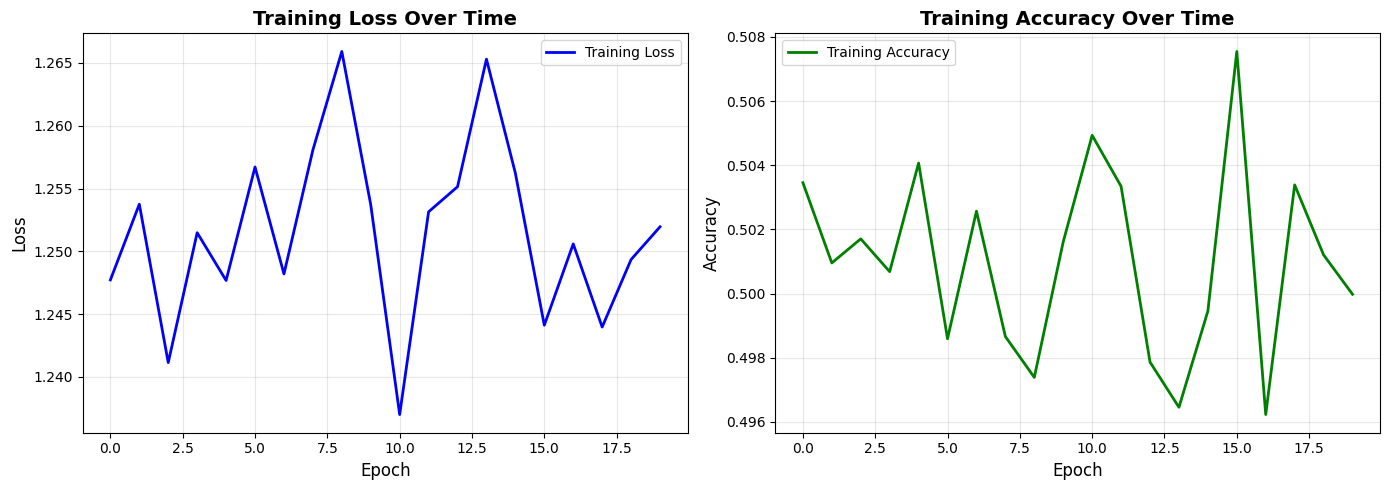

In [18]:
# ============================================================================
# SECTION 8: Training History Visualization
# ============================================================================

def plot_training_history(history):
    """Plot training loss and accuracy."""
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Plot loss
    axes[0].plot(history.history['loss'], 'b-', linewidth=2, label='Training Loss')
    axes[0].set_xlabel('Epoch', fontsize=12)
    axes[0].set_ylabel('Loss', fontsize=12)
    axes[0].set_title('Training Loss Over Time', fontsize=14, fontweight='bold')
    axes[0].grid(True, alpha=0.3)
    axes[0].legend()
    
    # Plot accuracy
    axes[1].plot(history.history['accuracy'], 'g-', linewidth=2, label='Training Accuracy')
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('Accuracy', fontsize=12)
    axes[1].set_title('Training Accuracy Over Time', fontsize=14, fontweight='bold')
    axes[1].grid(True, alpha=0.3)
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()

# Plot training history
if EPOCHS > 1:
    plot_training_history(history)
else:
    print("Note: Run for more epochs to see training curves\n")

In [19]:
# ============================================================================
# SECTION 9: Model Summary and Statistics
# ============================================================================

print("="*60)
print("TRAINING SUMMARY")
print("="*60)

final_loss = history.history['loss'][-1]
final_accuracy = history.history['accuracy'][-1]

print(f"Final Training Loss: {final_loss:.6f}")
print(f"Final Training Accuracy: {final_accuracy:.4f}")
print(f"Total Parameters: {model.count_params():,}")
print(f"Model saved to: {MODEL_PATH}/{MODEL_NAME}")
print("="*60 + "\n")

TRAINING SUMMARY
Final Training Loss: 1.251954
Final Training Accuracy: 0.5000
Total Parameters: 523,329
Model saved to: ../models/wakeword_model.h5



In [20]:
# ============================================================================
# SECTION 10: Save and Verify Model
# ============================================================================

# Save model explicitly
model.save(f"{MODEL_PATH}/{MODEL_NAME}")
print(f"✓ Model saved to: {MODEL_PATH}/{MODEL_NAME}\n")

# Verify model can be loaded
print("Verifying saved model...")
loaded_model = load_model(f"{MODEL_PATH}/{MODEL_NAME}")
print("✓ Model loaded successfully!")
print(f"✓ Model verification complete!\n")

# Compare architectures
print("Model Verification:")
print(f"  Original parameters: {model.count_params():,}")
print(f"  Loaded parameters: {loaded_model.count_params():,}")
print(f"  Match: {model.count_params() == loaded_model.count_params()}")

✓ Model saved to: ../models/wakeword_model.h5

Verifying saved model...
✓ Model loaded successfully!
✓ Model verification complete!

Model Verification:
  Original parameters: 523,329
  Loaded parameters: 523,329
  Match: True


In [21]:
# ============================================================================
# SECTION 11: Model Information Export
# ============================================================================

# Save training configuration and results
training_info = {
    'timestamp': datetime.now().isoformat(),
    'model_name': MODEL_NAME,
    'architecture': {
        'input_shape': (Tx, N_FREQ),
        'output_shape': (Ty, 1),
        'total_parameters': int(model.count_params())
    },
    'training_config': {
        'batch_size': BATCH_SIZE,
        'epochs': EPOCHS,
        'learning_rate': LEARNING_RATE,
        'optimizer': 'Adam',
        'loss': 'binary_crossentropy'
    },
    'training_results': {
        'final_loss': float(final_loss),
        'final_accuracy': float(final_accuracy),
        'training_samples': int(X_train.shape[0])
    }
}

# Save to JSON
info_path = f"{MODEL_PATH}/training_info.json"
with open(info_path, 'w') as f:
    json.dump(training_info, f, indent=4)

print(f"\n✓ Training information saved to: {info_path}")

print("\n" + "="*60)
print("MODEL TRAINING COMPLETE!")
print("="*60)
print("\nNext steps:")
print("  1. Increase EPOCHS for better performance")
print("  2. Load development set for validation")
print("  3. Test model on new audio samples")
print("  4. Deploy model for real-time detection")
print("="*60)


✓ Training information saved to: ../models/training_info.json

MODEL TRAINING COMPLETE!

Next steps:
  1. Increase EPOCHS for better performance
  2. Load development set for validation
  3. Test model on new audio samples
  4. Deploy model for real-time detection
